## Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryasan","key":"43152887e774fd19e6300a7b8da5fa60"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!pip install -q kaggle


In [ ]:
!kaggle datasets download -d tommyngx/digital-knee-xray
!unzip -q digital-knee-xray.zip -d digital-knee-xray

!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity
!unzip -q knee-osteoarthritis-dataset-with-severity.zip -d knee-osteoarthritis

Dataset URL: https://www.kaggle.com/datasets/tommyngx/digital-knee-xray
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 114M/117M [00:00<00:00, 553MB/s] 
100% 117M/117M [00:00<00:00, 560MB/s]
Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)
 93% 190M/204M [00:00<00:00, 249MB/s]
100% 204M/204M [00:00<00:00, 267MB/s]


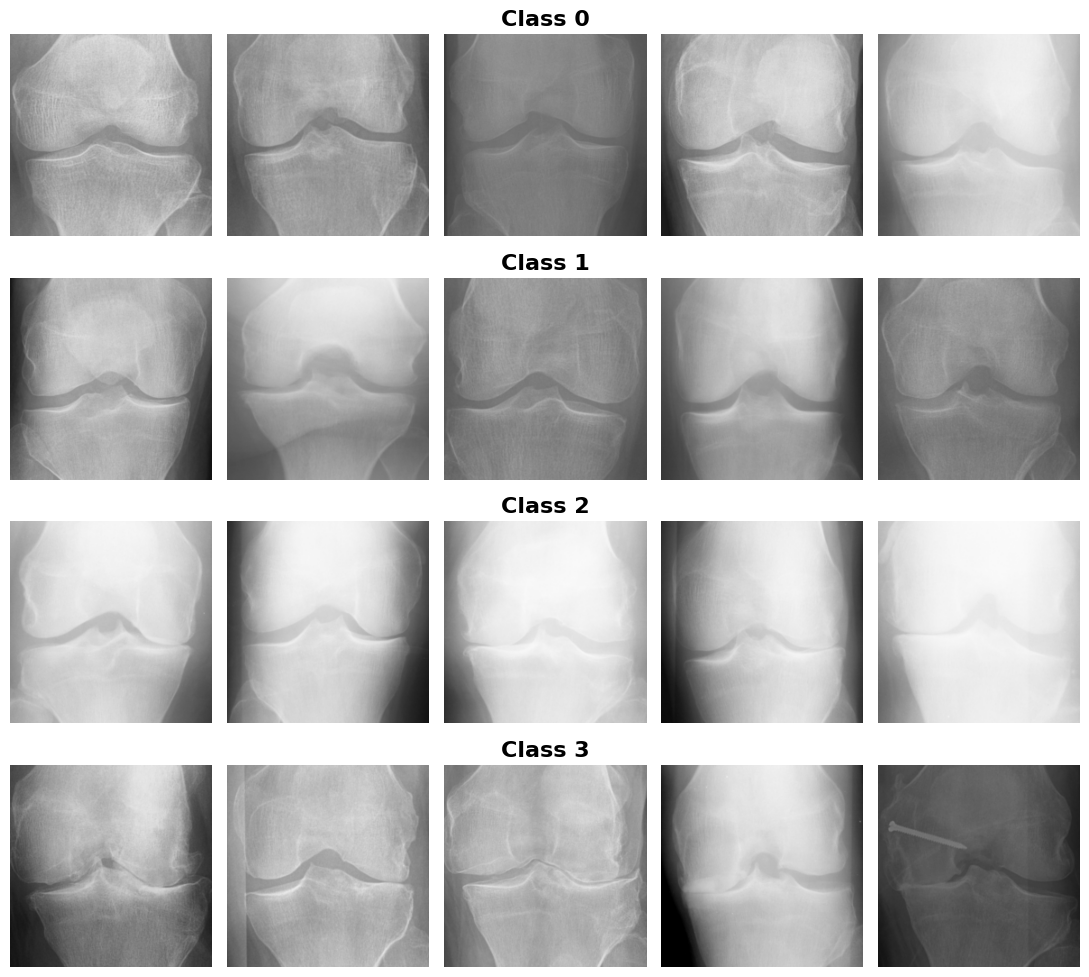

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os


folders = [
    "/content/knee-osteoarthritis/train/0",
    "/content/knee-osteoarthritis/train/2",
    "/content/knee-osteoarthritis/train/3",
    "/content/knee-osteoarthritis/train/4"
]


labels = ["Class 0", "Class 1", "Class 2", "Class 3"]

plt.figure(figsize=(11, 10))

for i, folder in enumerate(folders):

    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

    for j, img_file in enumerate(images):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        plt.subplot(4, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.axis('off')

        if j == 2:
            plt.title(labels[i], fontsize=16, fontweight='bold', loc='center')

plt.tight_layout()
plt.show()


## Loading YOLO model

In [ ]:
#loading YOLOv8 knee joint detection model

from google.colab import files

uploaded = files.upload()

Saving cv_yolo_model_last.pt to cv_yolo_model_last.pt


In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

yolo_model = YOLO('/content/cv_yolo_model_last.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Preprocessing

In [ ]:
import cv2
import numpy as np
from collections import deque

class KneeProcessor:
    def __init__(self, model, class_id=0, conf_threshold=0.65, overlap_threshold=0.0, knee_distance_threshold_ratio=0.25):
        self.model = model
        self.class_id = class_id
        self.conf_threshold = conf_threshold
        self.overlap_threshold = overlap_threshold
        self.knee_distance_threshold_ratio = knee_distance_threshold_ratio

        self.recent_originals = deque(maxlen=4)
        self.recent_clahe = deque(maxlen=4)
        self.recent_yolo_annotated = deque(maxlen=4)
        self.recent_cropped = deque(maxlen=4)
        self.recent_resized = deque(maxlen=4)

        self.skipped_images = []
        self.failed_images = []
        self.two_joint_images = []

    def apply_clahe(self, img):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(img)

    def to_3channels(self, img):
        if len(img.shape) == 2:
            return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img

    def resize_with_padding(self, image, target_size=(224, 224)):
        h, w = image.shape[:2]
        scale = min(target_size[0] / h, target_size[1] / w)
        resized = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

        top_pad = (target_size[0] - resized.shape[0]) // 2
        bottom_pad = target_size[0] - resized.shape[0] - top_pad
        left_pad = (target_size[1] - resized.shape[1]) // 2
        right_pad = target_size[1] - resized.shape[1] - left_pad

        return cv2.copyMakeBorder(resized, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_REPLICATE)

    def iou(self, box1, box2):
        x1, y1, x2, y2 = box1
        x1_p, y1_p, x2_p, y2_p = box2
        xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
        xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2_p - x1_p) * (y2_p - y1_p)
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0

    def filter_non_overlapping_top2(self, boxes, scores):
        valid = [(box, score) for box, score in zip(boxes, scores) if score >= self.conf_threshold]
        valid.sort(key=lambda x: x[1], reverse=True)

        selected = []
        for box, score in valid:
            if all(self.iou(box, s[0]) <= self.overlap_threshold for s in selected):
                selected.append((box, score))
            if len(selected) == 2:
                break
        return [b for b, _ in selected]

    def crop_around_joint(self, img, box, target_size=(224, 224), margin=20, vertical_extra=20):
        x1, y1, x2, y2 = map(int, box)
        h, w = img.shape[:2]

        y1 = max(y1 - vertical_extra, 0)
        y2 = min(y2 + vertical_extra, h)
        x1 = max(x1 - margin, 0)
        x2 = min(x2 + margin, w)

        cropped = img[y1:y2, x1:x2]
        resized = self.resize_with_padding(cropped, target_size)
        return cropped, resized

    def crop_knee_joint_yolo(self, img_path, target_size=(224, 224), margin=10):
        img = cv2.imread(img_path)
        if img is None:
            print(f" فشل في تحميل الصورة: {img_path}")
            return [], []


        self.recent_originals.append(img.copy())


        img_clahe = self.apply_clahe(img)
        self.recent_clahe.append(img_clahe.copy())

        img_clahe_3ch = self.to_3channels(img_clahe)

        results = self.model(img_clahe_3ch, verbose=False)
        detections = results[0].boxes.data.cpu().numpy()

        boxes = []
        scores = []
        for det in detections:
            if int(det[5]) == self.class_id:
                boxes.append(det[:4])
                scores.append(float(det[4]))

        selected_boxes = self.filter_non_overlapping_top2(boxes, scores)
        cropped_joints = []

        annotated = img_clahe_3ch.copy()
        for box, score in zip(selected_boxes, scores):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = "Joint Detected"
            cv2.putText(annotated, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        self.recent_yolo_annotated.append(annotated)

        if len(selected_boxes) == 2:
            x_centers = [((box[0] + box[2]) / 2) for box in selected_boxes]
            x_centers.sort()
            min_dist = abs(x_centers[1] - x_centers[0])
            img_width = img_clahe.shape[1]
            if min_dist / img_width < self.knee_distance_threshold_ratio:
                self.failed_images.append(img_clahe_3ch.copy())
                return [], []

            self.two_joint_images.append(img_clahe_3ch.copy())

        if len(selected_boxes) == 0:
            self.failed_images.append(img_clahe_3ch.copy())
            self.skipped_images.append(img_path)
            return [], []

        for box in selected_boxes:
            cropped, resized = self.crop_around_joint(img_clahe_3ch, box, target_size, margin)
            cropped_joints.append(resized)
            self.recent_cropped.append(cropped)
            self.recent_resized.append(resized)

        return cropped_joints, []


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

class DataPreprocessor:
    def __init__(self, num_classes, normalize=True, add_channel=True, one_hot=True):

        self.num_classes = num_classes
        self.normalize = normalize
        self.add_channel = add_channel
        self.one_hot = one_hot

    def process(self, X_list, y_list):

        X_np = np.array(X_list)
        y_np = np.array(y_list)


        if self.add_channel:
            if len(X_np.shape) == 3:  # (num_samples, height, width)
                X_np = np.expand_dims(X_np, axis=-1)  # (num_samples, height, width, 1)


        if self.normalize:
            X_np = X_np.astype(np.float32) / 255.0


        if self.one_hot:
            y_np = to_categorical(y_np, num_classes=self.num_classes)

        return X_np, y_np


## Extra

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_knee_processing_results(processor):
    # تجميع الصور من خصائص الكائن
    images = []

    if processor.recent_originals:
        images.append(processor.recent_originals[-1])
    if processor.recent_clahe:
        images.append(processor.recent_clahe[-1])
    if processor.recent_yolo_annotated:
        images.append(processor.recent_yolo_annotated[-1])
    for img in processor.recent_cropped:
        images.append(img)
    for img in processor.recent_resized:
        images.append(img)

    total = len(images)
    cols = min(5, total)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(len(axes)):
        if i < total:
            img = images[i]
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
            else:
                axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        else:
            axes[i].axis('off')


    plt.tight_layout()
    plt.show()


img_path = "/content/knee-osteoarthritis/train/4/9074437L.png"
processor = KneeProcessor(yolo_model)
cropped_imgs, _ = processor.crop_knee_joint_yolo(img_path)

show_knee_processing_results(processor)


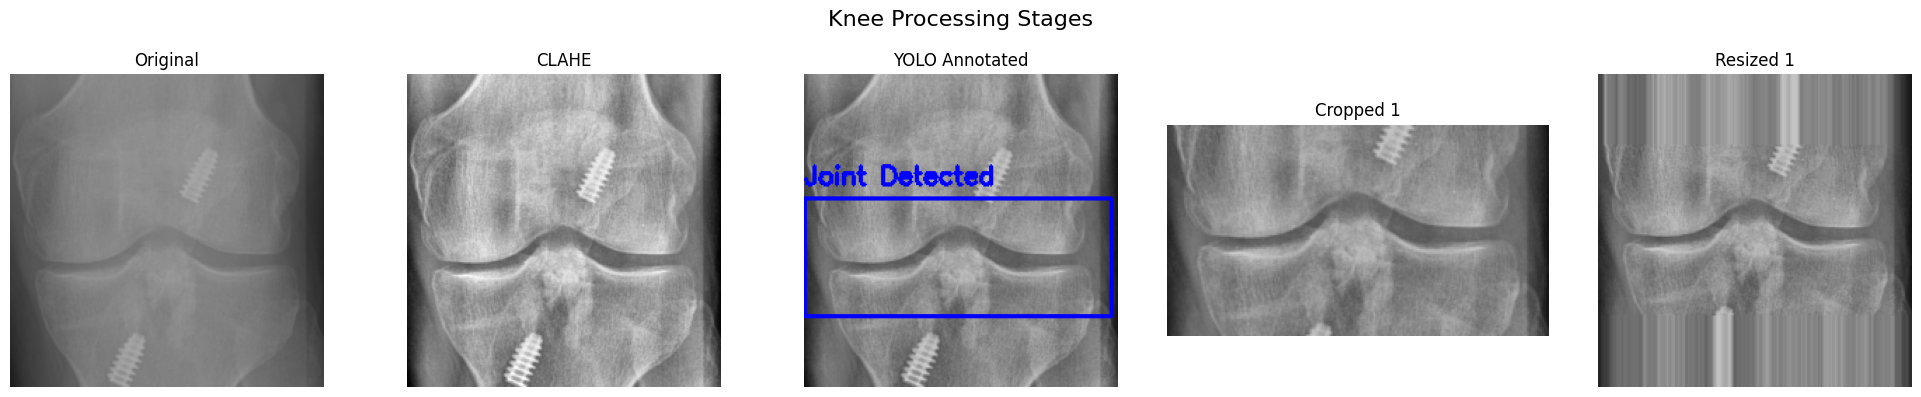

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_knee_processing_results(processor, title="Knee Processing Stages"):

    images = []
    titles = []

    if processor.recent_originals:
        images.append(processor.recent_originals[-1])
        titles.append("Original")
    if processor.recent_clahe:
        images.append(processor.recent_clahe[-1])
        titles.append("CLAHE")

    if processor.recent_yolo_annotated:
        images.append(processor.recent_yolo_annotated[-1])
        titles.append("YOLO Annotated")

    for i, img in enumerate(processor.recent_cropped):
        images.append(img)
        titles.append(f"Cropped {i+1}")

    for i, img in enumerate(processor.recent_resized):
        images.append(img)
        titles.append(f"Resized {i+1}")

    total = len(images)
    cols = min(5, total)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(len(axes)):
        if i < total:
            img = images[i]
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
            else:
                axes[i].imshow(img, cmap='gray')
            axes[i].set_title(titles[i], fontsize=12)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

img_path = "/content/knee-osteoarthritis/train/2/9528258L.png"

processor = KneeProcessor(yolo_model)
cropped_imgs, _ = processor.crop_knee_joint_yolo(img_path)

show_knee_processing_results(processor)


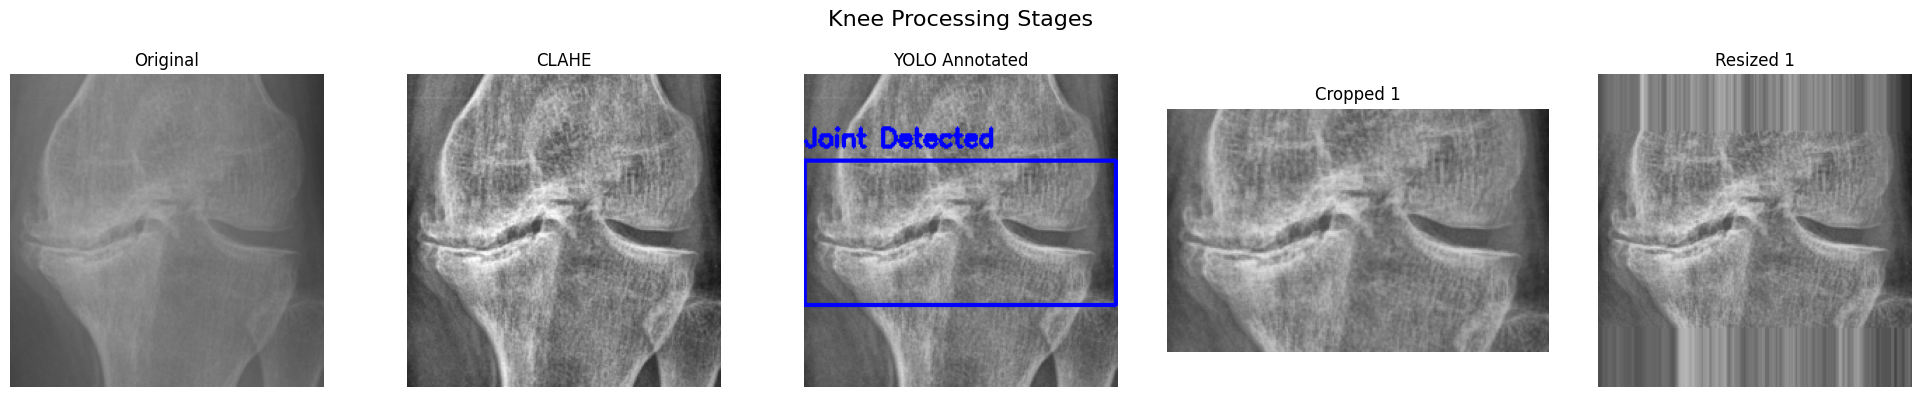

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_knee_processing_results(processor, title="Knee Processing Stages"):

    images = []
    titles = []

    if processor.recent_originals:
        images.append(processor.recent_originals[-1])
        titles.append("Original")
    if processor.recent_clahe:
        images.append(processor.recent_clahe[-1])
        titles.append("CLAHE")

    if processor.recent_yolo_annotated:
        images.append(processor.recent_yolo_annotated[-1])
        titles.append("YOLO Annotated")

    for i, img in enumerate(processor.recent_cropped):
        images.append(img)
        titles.append(f"Cropped {i+1}")

    for i, img in enumerate(processor.recent_resized):
        images.append(img)
        titles.append(f"Resized {i+1}")

    total = len(images)
    cols = min(5, total)
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(len(axes)):
        if i < total:
            img = images[i]
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
            else:
                axes[i].imshow(img, cmap='gray')
            axes[i].set_title(titles[i], fontsize=12)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

img_path = "/content/knee-osteoarthritis/train/4/9074437L.png"

processor = KneeProcessor(yolo_model)
cropped_imgs, _ = processor.crop_knee_joint_yolo(img_path)

show_knee_processing_results(processor)


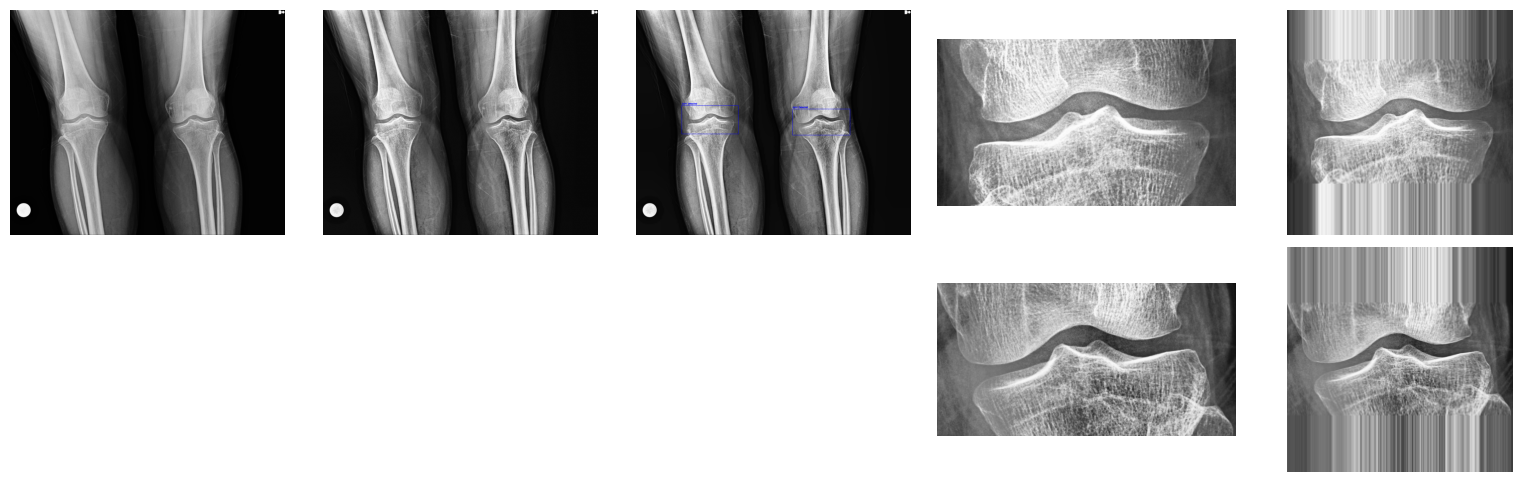

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

def show_custom_vertical_in_row(processor):

    images = []
    if processor.recent_originals:
        images.append(processor.recent_originals[-1])
    if processor.recent_clahe:
        images.append(processor.recent_clahe[-1])
    if processor.recent_yolo_annotated:
        images.append(processor.recent_yolo_annotated[-1])
    for img in processor.recent_cropped:
        images.append(img)
    for img in processor.recent_resized:
        images.append(img)

    fig = plt.figure(figsize=(20, 6))


    gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.05, hspace=0.05)


    for i in range(3):
        ax = fig.add_subplot(gs[0, i])
        img = images[i]
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img if len(img.shape)==3 else img, cmap='gray')
        ax.axis('off')


    for idx, i in enumerate(range(3, 5)):
        ax = fig.add_subplot(gs[idx, 3])
        img = images[i]
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img if len(img.shape)==3 else img, cmap='gray')
        ax.axis('off')

    for idx, i in enumerate(range(5, 7)):
        ax = fig.add_subplot(gs[idx, 4])
        img = images[i]
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img if len(img.shape)==3 else img, cmap='gray')
        ax.axis('off')

    plt.show()


processor = KneeProcessor(yolo_model)
cropped_imgs, _ = processor.crop_knee_joint_yolo("/content/OP107.jpg")

show_custom_vertical_in_row(processor)


In [ ]:
preprocessor_ = KneeProcessor(yolo_model)

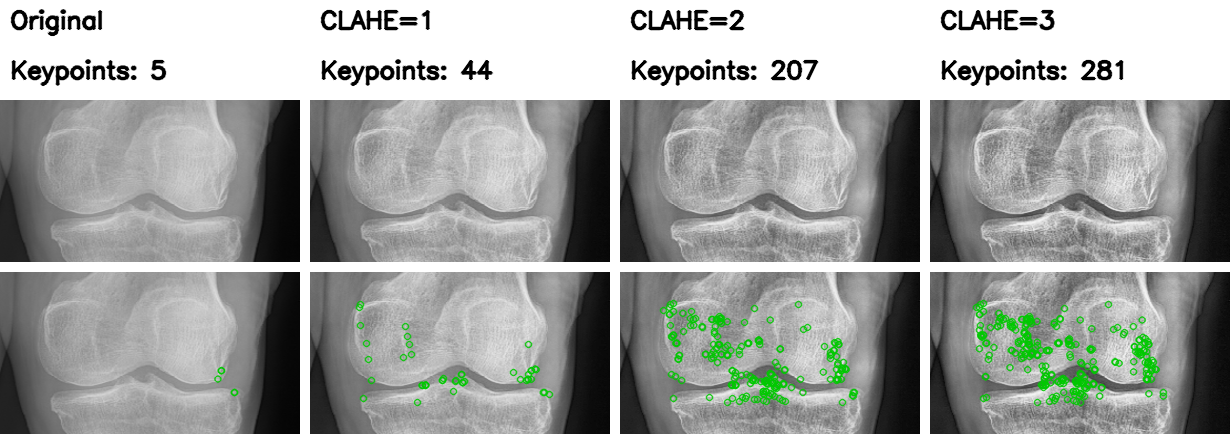

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image in grayscale
img = cv2.imread("/content/digital-knee-xray/MedicalExpert-II/2Mild/MildG2 (10).png", cv2.IMREAD_GRAYSCALE)

def count_keypoints(image):
    orb = cv2.ORB_create()
    keypoints = orb.detect(image, None)
    return len(keypoints), keypoints

def apply_clahe(image, clip_limit):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    return clahe.apply(image)

def make_text_image(text, width, height=40):
    # Create a white image with text
    img = np.ones((height, width, 3), dtype=np.uint8) * 255
    cv2.putText(img, text, (10, int(height * 0.7)), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 0, 0), 2, cv2.LINE_AA)
    return img

def make_separator(width, height=10):
    # Create a white separator image
    return np.ones((height, width, 3), dtype=np.uint8) * 255

def prepare_column(title, img_gray):
    # Count keypoints
    kp_count, kp = count_keypoints(img_gray)

    # Image with keypoints drawn
    img_with_kp = cv2.drawKeypoints(img_gray, kp, None, color=(0,200,0))

    # Convert grayscale images to BGR for displaying with text
    img_gray_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    img_with_kp_bgr = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

    width = img_gray_bgr.shape[1]

    # Prepare text images and separators
    title_img = make_text_image(title, width)
    kp_img = make_text_image(f"Keypoints: {kp_count}", width)
    separator = make_separator(width)

    # Stack the column with separators between each part
    column = np.vstack([
        title_img,
        separator,
        kp_img,
        separator,
        img_gray_bgr,
        separator,
        img_with_kp_bgr
    ])
    return column

# Prepare columns
columns = []

# First column - original image
columns.append(prepare_column("Original", img))

# Other columns - images after CLAHE
clahe_values = [1, 2, 3]
for clip in clahe_values:
    img_clahe = apply_clahe(img, clip)
    columns.append(prepare_column(f"CLAHE={clip}", img_clahe))

# Standardize the heights
min_height = min(col.shape[0] for col in columns)
columns = [col[:min_height, :, :] for col in columns]

# Vertical gap between columns
gap_width = 10
gap = np.ones((min_height, gap_width, 3), dtype=np.uint8) * 255

# Merge columns with gaps
final_img = columns[0]
for col in columns[1:]:
    final_img = np.hstack([final_img, gap, col])

# Display the final image
cv2_imshow(final_img)


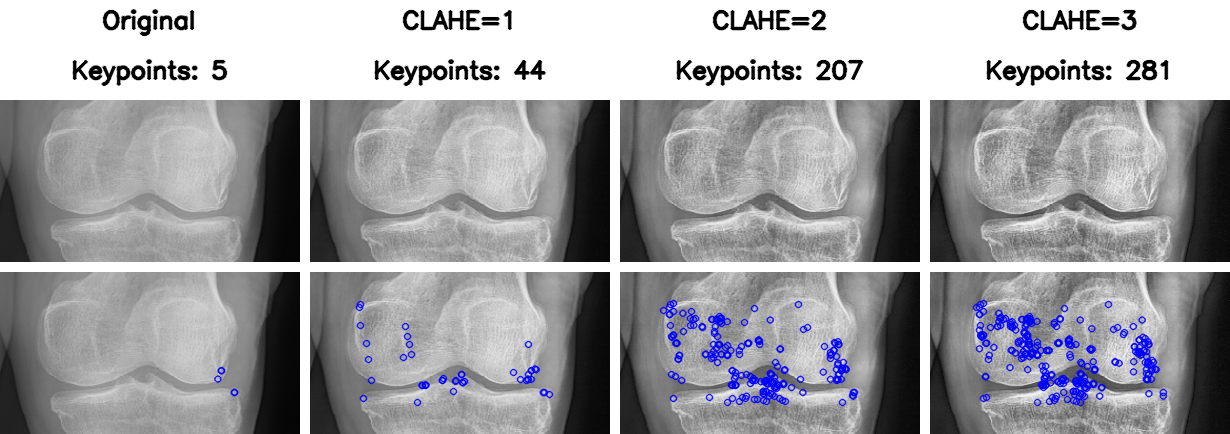

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/digital-knee-xray/MedicalExpert-II/2Mild/MildG2 (10).png", cv2.IMREAD_GRAYSCALE)

def count_keypoints(image):
    orb = cv2.ORB_create()
    keypoints = orb.detect(image, None)
    return len(keypoints), keypoints

def apply_clahe(image, clip_limit):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    return clahe.apply(image)

def make_text_image_centered(text, width, height=40):
    img = np.ones((height, width, 3), dtype=np.uint8) * 255
    font_scale = 0.8
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX

    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_width = text_size[0]

    x = (width - text_width) // 2
    y = int(height * 0.7)

    cv2.putText(img, text, (x, y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)
    return img

def make_separator(width, height=10):
    return np.ones((height, width, 3), dtype=np.uint8) * 255

def prepare_column(title, img_gray):

    kp_count, kp = count_keypoints(img_gray)


    img_with_kp = cv2.drawKeypoints(img_gray, kp, None, color=(0, 0, 255))



    img_gray_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    img_with_kp_bgr = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

    width = img_gray_bgr.shape[1]

    title_img = make_text_image_centered(title, width)
    kp_img = make_text_image_centered(f"Keypoints: {kp_count}", width)
    separator = make_separator(width)


    column = np.vstack([
        title_img,
        separator,
        kp_img,
        separator,
        img_gray_bgr,
        separator,
        img_with_kp_bgr
    ])
    return column


columns = []

columns.append(prepare_column("Original", img))

clahe_values = [1, 2, 3]
for clip in clahe_values:
    img_clahe = apply_clahe(img, clip)
    columns.append(prepare_column(f"CLAHE={clip}", img_clahe))

min_height = min(col.shape[0] for col in columns)
columns = [col[:min_height, :, :] for col in columns]


gap_width = 10
gap = np.ones((min_height, gap_width, 3), dtype=np.uint8) * 255


final_img = columns[0]
for col in columns[1:]:
    final_img = np.hstack([final_img, gap, col])


cv2_imshow(final_img)


# Loading Data

In [ ]:
import gc
gc.collect()

22

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm


data_folders = [
    #"/content/knee-osteoarthritis/train",
    #"/content/knee-osteoarthritis/val",
   # "/content/knee-osteoarthritis/auto_test",
    #"/content/digital-knee-xray/MedicalExpert-I",
   #"/content/digital-knee-xray/MedicalExpert-II",
    "/content/knee-osteoarthritis/test",
]



last_failed_image = None

def load_knees_and_process_yolo(folders, preprocessor, limit_per_class=None):
    X = []
    y = []
    fallback_images = []
    fallback_labels = []

    label_map = {"0": 0, "2": 1, "3": 2, "4": 3}
    class_counts = {new_label: 0 for new_label in label_map.values()}

    for folder in folders:
        if not os.path.exists(folder):
            print(f" المسار غير موجود: {folder}")
            continue

        for class_folder in os.listdir(folder):
            class_path = os.path.join(folder, class_folder)
            if not os.path.isdir(class_path):
                continue

            original_label = None
            for i in range(5):
                if class_folder.startswith(str(i)):
                    original_label = str(i)
                    break

            if original_label is None or original_label == "1" or original_label not in label_map:
                continue

            new_label = label_map[original_label]

            for img_name in tqdm(os.listdir(class_path), desc=f"تحميل فئة {original_label} من {folder}"):
                if limit_per_class is not None and class_counts[new_label] >= limit_per_class:
                    break

                img_path = os.path.join(class_path, img_name)

                try:
                    cropped_imgs, fallback = preprocessor.crop_knee_joint_yolo(img_path)

                    for img in cropped_imgs:
                        X.append(img)
                        y.append(new_label)
                        class_counts[new_label] += 1

                    for f_img in fallback:
                        fallback_images.append(f_img)
                        fallback_labels.append(new_label)

                except Exception as e:
                    print(f"\n error: {img_path} => {e}")
                    continue

    return X, y, class_counts, fallback_images, fallback_labels



In [ ]:
processor = KneeProcessor(yolo_model)
X_all, y_all, all_class_counts, fallback_imgs, fallback_lbls = load_knees_and_process_yolo(data_folders, processor)

تحميل فئة 2 من /content/knee-osteoarthritis/test: 100%|██████████| 447/447 [00:06<00:00, 72.63it/s]


In [ ]:
import numpy as np

np.save("X_all.npy", X_all)
np.save("y_all.npy", y_all)

import zipfile

with zipfile.ZipFile("OA_test.zip", "w") as zipf:
    zipf.write("X_all.npy")
    zipf.write("y_all.npy")

from google.colab import files

files.download("OA_test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# طباعة النتائج
print("\n🔢 عدد الصور المحملة لكل فئة:")
for class_label, count in all_class_counts.items():
    print(f"الفئة {class_label}: {count} صورة")

print(len(y_all))


🔢 عدد الصور المحملة لكل فئة:
الفئة 0: 3855 صورة
الفئة 1: 2578 صورة
الفئة 2: 1286 صورة
الفئة 3: 294 صورة
8013


In [ ]:
def print_skipped_images(processor):
    print("=== Skipped Images ===")
    if not processor.skipped_images:
        print("No skipped images.")
    else:
        for i, img_name in enumerate(processor.skipped_images, 1):
            print(f"{i}. {img_name}")

def print_failed_images(processor):
    print("=== Failed Images ===")
    if not processor.failed_images:
        print("No failed images.")
    else:
        for i, img_name in enumerate(processor.failed_images, 1):
            print(f"{i}. {img_name}")

def print_two_joint_images(processor):
    print("=== Two Joint Images ===")
    if not processor.two_joint_images:
        print("No images with two joints.")
    else:
        for i, img_name in enumerate(processor.two_joint_images, 1):
            print(f"{i}. {img_name}")


In [ ]:
print_skipped_images(processor)

=== Skipped Images ===
No skipped images.


In [ ]:
print_failed_images(processor)

=== Failed Images ===
No failed images.


In [ ]:
print_two_joint_images(processor)


=== Two Joint Images ===
No images with two joints.
